In [ ]:
3 import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics
from sklearn.model_selection import train_test_split

import os

import datetime

import seaborn as sns
from tqdm.notebook import tqdm
torch.manual_seed(17)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset"
batchnormdrpout_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/batchnormdrp"
train_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/train"
val_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/val"
test_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/test"

# Data Prep

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.RandomGrayscale(p=0.05),
        #transforms.RandomHorizontalFlip(p=0.1), 
        transforms.RandomVerticalFlip(p=0.08),
        transforms.RandomRotation(10),
        #transforms.RandomPerspective(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    "val": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]),
    "test": transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
}


train_dataset = datasets.ImageFolder(
                              root = train_path,
                              transform = image_transforms["train"]
                       )

val_dataset = datasets.ImageFolder(
                              root = val_path,
                              transform = image_transforms["val"]
                       )

test_dataset = datasets.ImageFolder(
                              root = test_path,
                              transform = image_transforms["test"]
                       )

print("Training length: ", len(train_dataset))
print("Validation length: ", len(val_dataset))
print("Testing length: ", len(test_dataset))

dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=124, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_dataset, batch_size=124, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Training length:  11964
Validation length:  2279
Testing length:  910


# Eval functions

In [ ]:
# Functions to create confusion matrix

def get_confusion_tensor(preds, targets):
  stacked = torch.stack(
      (
          torch.cat(targets, dim=0)
          ,torch.cat(preds, dim=0)
      )
      ,dim=1
  )
  cmt = torch.zeros(3,3, dtype=torch.int64)
  for p in stacked:
      tl, pl = p.tolist()
      cmt[int(tl), int(pl)] = cmt[int(tl), int(pl)] + 1
  return cmt

def plot_confusion_matrix(preds, targets, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  cm = get_confusion_tensor(preds, targets)

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

# Model

In [ ]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
#                 dilation=1, groups=1, bias=True, padding_mode='zeros')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 10)
        self.conv3 = nn.Conv2d(64, 128, 20)
        self.fc1 = nn.Linear(128*25*25, 120)
        self.fc2 = nn.Linear(120, 3)
        self.batchNorm1 = nn.BatchNorm2d(32, momentum=0.04)
        self.batchNorm2 = nn.BatchNorm2d(64, momentum=0.06)
        self.batchNorm3 = nn.BatchNorm2d(128, momentum=0.06)
        self.dropout1 = torch.nn.Dropout(p=0.08)
        self.dropout2 = torch.nn.Dropout(p=0.10)

    def forward(self, x):
      #print("Start: ",x.shape)
      x = self.batchNorm1(self.conv1(x))
      #print("conv1: ",x.shape)
      x = self.pool(F.relu(x))
      #print("first pool: ",x.shape)
      x= self.batchNorm2(self.conv2(x))
      #print("conv2: ", x.shape)
      x = self.dropout1(self.pool(F.relu(x)))
      #print("second pool: ",x.shape)
      x= self.batchNorm3(self.conv3(x))
      #print("conv3: ", x.shape)
      x = self.dropout2(self.pool(F.relu(x)))
      #print("second pool: ",x.shape)
      x = x.view(x.size(0), -1)
      #print("x.view: ", x.shape)
      #x = x.view(-1, 16 * 5 * 5)
      x = self.fc1(x)
      #print("FC1 ", x.shape)
      x = F.relu(x)
      #print("relu fc1: ", x.shape)
      x = self.fc2(x)
      #print("FC2 ", x.shape)
      x = F.relu(x)
      #print("relu fc2: ", x.shape)
      return x

# Training Function

In [ ]:
def train_model(n_epochs, print_every):
  

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)    

  valid_loss_min = np.Inf
  loss_history=[]  
  correct_history=[]  
  val_loss_history=[]  
  val_correct_history=[]  
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(dataloader_train)
  for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(dataloader_train):
      net.train()
      data_, target_ = data_.to(device), target_.to(device)
      optimizer.zero_grad()
      
      outputs = net(data_)
      loss = criterion(outputs, target_)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _,pred = torch.max(outputs, dim=1)
      correct += torch.sum(pred==target_).item()
      total += target_.size(0)
      if (batch_idx) % print_every == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
      net.eval()
      for data_t, target_t in (dataloader_valid):
        data_t, target_t = data_t.to(device), target_t.to(device)
        outputs_t = net(data_t)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        total_t += target_t.size(0)
      val_acc.append(100 * correct_t/total_t)
      val_loss.append(batch_loss/len(dataloader_valid))
      network_learned = batch_loss < valid_loss_min
      print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
      if network_learned:
        valid_loss_min = batch_loss
        torch.save(net.state_dict(), batchnormdrpout_chkpt_path+'/'+str(n_epochs)+'_batchNorm.pt')
        print('Improvement-Detected, save-model')

    epoch_loss=running_loss/len(dataloader_train)
    epoch_acc=correct/total
    loss_history.append(epoch_loss)
    correct_history.append(epoch_acc)
    val_epoch_loss=batch_loss/len(dataloader_valid)
    val_epoch_acc=correct_t/total_t
    val_loss_history.append(val_epoch_loss)
    val_correct_history.append(val_epoch_acc)
      
  return loss_history, val_loss_history, train_acc, val_acc

# Experiment 4 - 30 Epochs

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net.to(device)
loss_history, val_loss_history, train_acc, val_acc = train_model(30, 50)

Epoch 1

Epoch [1/30], Step [0/97], Loss: 1.1483
Epoch [1/30], Step [50/97], Loss: 0.7460

train-loss: 0.7838, train-acc: 65.4213
validation loss: 0.7736, validation acc: 72.8828

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/97], Loss: 0.6528
Epoch [2/30], Step [50/97], Loss: 0.7796

train-loss: 0.7125, train-acc: 75.0334
validation loss: 0.6898, validation acc: 77.2707

Improvement-Detected, save-model
Epoch 3

Epoch [3/30], Step [0/97], Loss: 0.6034
Epoch [3/30], Step [50/97], Loss: 0.5390

train-loss: 0.6705, train-acc: 77.3571
validation loss: 0.6466, validation acc: 80.6055

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/97], Loss: 0.5675
Epoch [4/30], Step [50/97], Loss: 0.5857

train-loss: 0.6409, train-acc: 79.1876
validation loss: 0.6143, validation acc: 82.2729

Improvement-Detected, save-model
Epoch 5

Epoch [5/30], Step [0/97], Loss: 0.5364
Epoch [5/30], Step [50/97], Loss: 0.5029

train-loss: 0.6173, train-acc: 80.9930
validation loss: 0

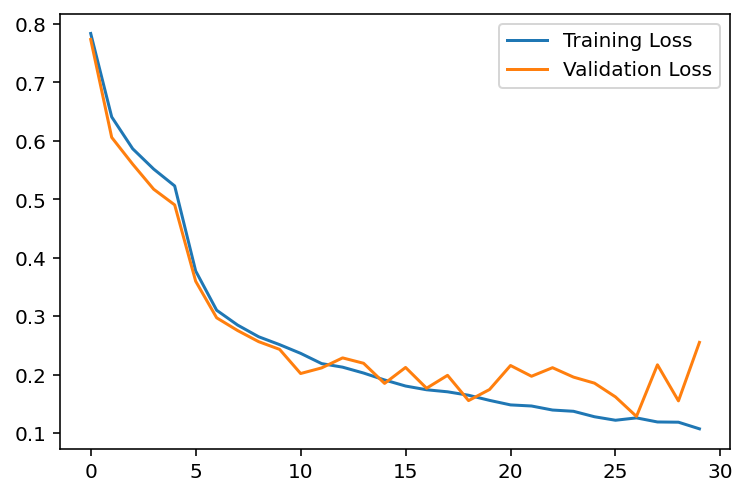

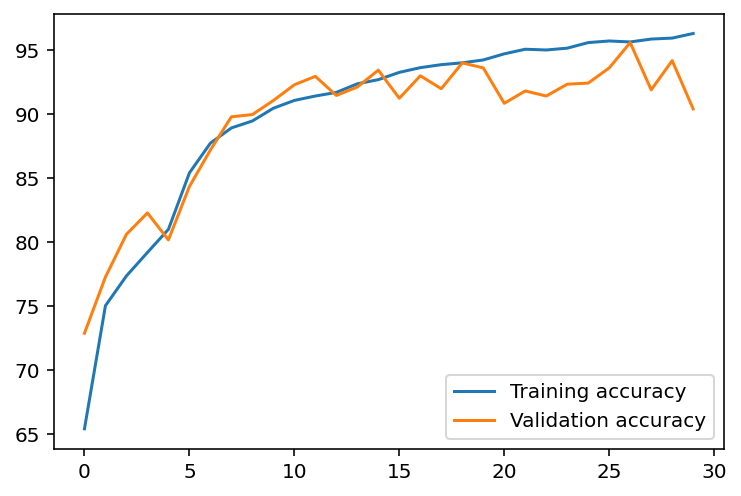

In [ ]:
plt.plot(loss_history,label='Training Loss')  
plt.plot(val_loss_history,label='Validation Loss')  
plt.legend()  
plt.show()  
plt.plot(train_acc,label='Training accuracy')  
plt.plot(val_acc,label='Validation accuracy')  
plt.legend()  
plt.show()

In [ ]:
total_t=0
correct_t=0
all_preds = []
all_labels = []
with torch.no_grad():
  net.eval()
  for data_t, target_t in (dataloader_test):
      data_t, target_t = data_t.to(device), target_t.to(device)
      outputs_t = net(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
      all_preds.append(pred_t)
      all_labels.append(target_t)
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct_t / total_t))

Accuracy of the network on the test images: 90 %


tensor([[142,  73,   2],
        [  2, 610,   0],
        [  0,   6,  75]])


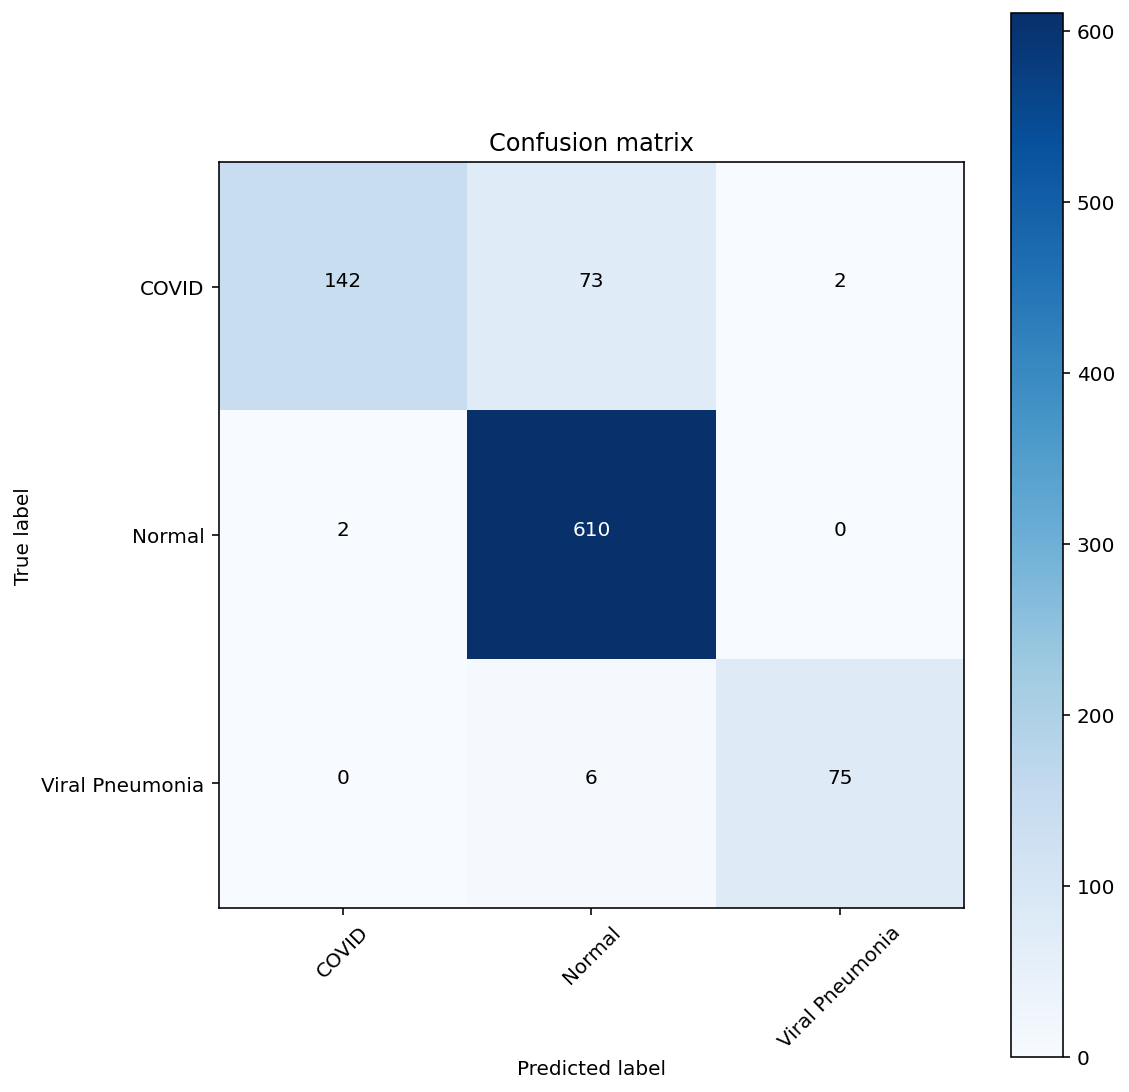

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

In [ ]:
print('\n*Classification Report:\n', metrics.classification_report(torch.cat(all_labels, dim=0).detach().cpu().numpy(), torch.cat(all_preds, dim=0).detach().cpu().numpy(), target_names=['COVID', 'Normal', 'Viral Pneumonia']))



*Classification Report:
                  precision    recall  f1-score   support

          COVID       0.99      0.65      0.79       217
         Normal       0.89      1.00      0.94       612
Viral Pneumonia       0.97      0.93      0.95        81

       accuracy                           0.91       910
      macro avg       0.95      0.86      0.89       910
   weighted avg       0.92      0.91      0.90       910

